<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#module-import" data-toc-modified-id="module-import-1">module import</a></span></li><li><span><a href="#JSON-파일에서-읽어들이기" data-toc-modified-id="JSON-파일에서-읽어들이기-2">JSON 파일에서 읽어들이기</a></span></li><li><span><a href="#저장된-텍스트-파일에서-읽어들이기" data-toc-modified-id="저장된-텍스트-파일에서-읽어들이기-3">저장된 텍스트 파일에서 읽어들이기</a></span></li><li><span><a href="#Data-추출하기" data-toc-modified-id="Data-추출하기-4">Data 추출하기</a></span></li></ul></div>

- http://www.engear.net/wp/topic-modeling-gensimpython/
- https://github.com/smilemango/lda_study

### module import

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### JSON 파일에서 읽어들이기

In [3]:
# Import Dataset
df = pd.read_json('newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


### 저장된 텍스트 파일에서 읽어들이기

In [4]:
content = []
with open("../text/19m_20181220_deominju_16000.txt", 'r') as f:
    while True:
        line = f.readline()
        if len(line) > 0:
            content.append(line)
        else:
            break

In [5]:
df = pd.DataFrame(content, columns=["content"])
df.head()

,content
0,"네, 반갑습니다.\n"
1,제 125차 정책조정회의 일을 상영표 원내대표에 모두 바로 가겠습니다.\n
2,11 12 월 이렇게 분위기가 이제 일주일 앞으로 다가왔습니다.\n
3,여야가 민생법안 처리를 위해서 노니의 속도를 더 내야겠습니다.\n
4,꼭 처리해야 할 일이 또 과제는 6300번 산업안전보건법입니다.\n


### Data 추출하기

In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:10])

['네, 반갑습니다. ',
 '제 125차 정책조정회의 일을 상영표 원내대표에 모두 바로 가겠습니다. ',
 '11 12 월 이렇게 분위기가 이제 일주일 앞으로 다가왔습니다. ',
 '여야가 민생법안 처리를 위해서 노니의 속도를 더 내야겠습니다. ',
 '꼭 처리해야 할 일이 또 과제는 6300번 산업안전보건법입니다. ',
 '하나유치원 선법은 오늘의 연애 법안소위에서 어머니들 예정입니다. ',
 '오늘 합의가 이루어지지 않을 경우 27분에 철인가 사실상 어렵습니다. ',
 '자유한국당 너 우리 아이들이 하는 마음이 조금이라도 있다면 6003번 노니의 접수 임해야 합니다. ',
 '지난번 정기국회 때처럼 법안처리를 연 시키려는 무슨 국민이 용납하지 않을 것입니다. ',
 '우리당은 오늘 처리될 수 있도록 최선을 다해서 열린 자세로 소방서에 임하겠습니다. ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:10])

[['반갑습니다'], ['정책조정회의', '일을', '상영표', '원내대표에', '모두', '바로', '가겠습니다'], ['이렇게', '분위기가', '이제', '일주일', '앞으로', '다가왔습니다'], ['여야가', '민생법안', '처리를', '위해서', '노니의', '속도를', '내야겠습니다'], ['처리해야', '일이', '과제는', '산업안전보건법입니다'], ['하나유치원', '선법은', '오늘의', '연애', '법안소위에서', '어머니들', '예정입니다'], ['오늘', '합의가', '이루어지지', '않을', '경우', '분에', '철인가', '사실상', '어렵습니다'], ['자유한국당', '우리', '아이들이', '하는', '마음이', '조금이라도', '있다면', '노니의', '접수', '임해야', '합니다'], ['지난번', '정기국회', '때처럼', '법안처리를', '시키려는', '무슨', '국민이', '용납하지', '않을', '것입니다'], ['우리당은', '오늘', '처리될', '있도록', '최선을', '다해서', '열린', '자세로', '소방서에', '임하겠습니다']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[:10]]])

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:10])

[['반갑습니다'], ['정책조정회의', '원내대표에', '바로', '가겠습니다'], ['이렇게', '분위기가', '일주일', '앞으로', '다가왔습니다'], ['여야가', '민생법안', '처리를', '위해서', '노니의', '속도를', '내야겠습니다'], ['처리해야', '과제는', '산업안전보건법입니다'], ['하나유치원', '오늘의', '연애', '법안소위에서', '어머니들', '예정입니다'], ['합의가', '이루어지지', '경우', '사실상', '어렵습니다'], ['자유한국당', '아이들이', '마음이', '조금이라도', '있다면', '노니의', '접수', '임해야', '합니다'], ['지난번', '정기국회', '때처럼', '법안처리를', '시키려는', '국민이', '용납하지', '않을', '것입니다'], ['우리당은', '있도록', '최선을', '다해서', '열린', '자세로', '소방서에', '임하겠습니다']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(17, 1), (18, 1), (19, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(26, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(11, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]]


In [12]:
id2word[0]

'반갑습니다'

In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[('반갑습니다', 1)],
 [('가겠습니다', 1), ('바로', 1), ('원내대표에', 1), ('정책조정회의', 1)],
 [('다가왔습니다', 1), ('분위기가', 1), ('앞으로', 1), ('이렇게', 1), ('일주일', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"채우기" + 0.058*"있습니다" + 0.058*"집회를" + 0.058*"정책조정회의" + 0.058*"택시업계에" + '
  '0.013*"우려가" + 0.007*"교정시험만큼" + 0.007*"극단적인" + 0.007*"기사님의" + 0.007*"동안"'),
 (1,
  '0.117*"합니다" + 0.099*"그리고" + 0.010*"철저하게" + 0.010*"가계부채도" + 0.010*"발표한" + '
  '0.010*"국민생명" + 0.010*"프로젝트" + 0.010*"점검하도록" + 0.010*"초에" + 0.010*"반갑습니다"'),
 (2,
  '0.149*"노력을" + 0.010*"메시지를" + 0.010*"특별대표가" + 0.010*"방황하면서" + 0.010*"발표했습니다" '
  '+ 0.010*"협상을" + 0.010*"총괄하는" + 0.010*"주목할만한" + 0.010*"내기까지" + 0.010*"이끌어"'),
 (3,
  '0.135*"대해서" + 0.057*"하겠습니다" + 0.047*"택시" + 0.047*"산업" + 0.011*"대책을" + '
  '0.011*"마련하는" + 0.006*"수립" + 0.006*"종합적인" + 0.006*"안전에" + 0.006*"사고들을"'),
 (4,
  '0.071*"있도록" + 0.066*"그리고" + 0.009*"앞으로" + 0.008*"핵심인물" + 0.008*"차단하고" + '
  '0.008*"우리가" + 0.008*"압박하고" + 0.008*"환경단체" + 0.008*"세무조사를" + 0.008*"명을"'),
 (5,
  '0.010*"구축하는데" + 0.010*"가능한" + 0.010*"정책역량을" + 0.010*"자영업에" + 0.010*"생태계를" + '
  '0.010*"집중할" + 0.010*"계획입니다" + 0.010*"혁신과" + 0.010*"성장이" + 0.010*"더불어민주당은"'),
 (6,
  '0.071*"것입니다" + 0.01

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.747794394119472

Coherence Score:  0.3558099785662441


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/alex/Documents/ai/business_model/voicemagic/env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.225781  0.006818       1        1  12.096663
17     0.035237 -0.000447       2        1  10.473689
8      0.051528 -0.119967       3        1   9.634120
6      0.013674  0.021842       4        1   9.120474
3      0.073782  0.170202       5        1   8.997776
0      0.050473 -0.090608       6        1   5.847239
4      0.018541  0.002843       7        1   5.258323
15     0.000039  0.007248       8        1   5.218459
11    -0.061768  0.001329       9        1   4.156058
5      0.002137 -0.003877      10        1   3.576196
9      0.003183  0.000042      11        1   3.275944
10     0.006445  0.002740      12        1   3.245178
7      0.004240  0.001890      13        1   3.097811
18     0.003365  0.010246      14        1   2.939940
2      0.005184  0.001569      15        1   2.802070
1      0.011358  0.004416      16        1   2.603423
16     0.001865  0.002987      17        1   2.270205
12     0.000648  0.003721      18        1   2.028461
13    -0.009097  0.012140      19        1   1.919194
19     0.014946 -0.035134      20        1   1.438774, topic_info=    Category       Freq     Term      Total  loglift  logprob
402  Default  12.000000      대해서  12.000000  30.0000  30.0000
15   Default  11.000000      위해서  11.000000  29.0000  29.0000
497  Default   9.000000     있습니다   9.000000  28.0000  28.0000
241  Default  10.000000      통해서  10.000000  27.0000  27.0000
223  Default   7.000000      그리고   7.000000  26.0000  26.0000
230  Default   4.000000      노력을   4.000000  25.0000  25.0000
405  Default   8.000000     드립니다   8.000000  24.0000  24.0000
38   Default   4.000000      합니다   4.000000  23.0000  23.0000
131  Default   4.000000     바랍니다   4.000000  22.0000  22.0000
39   Default   6.000000     것입니다   6.000000  21.0000  21.0000
8    Default   4.000000      이렇게   4.000000  20.0000  20.0000
53   Default   4.000000      있도록   4.000000  19.0000  19.0000
61   Default   5.000000    하겠습니다   5.000000  18.0000  18.0000
63   Default   2.000000  산업안전보건법   2.000000  17.0000  17.0000
687  Default   3.000000      채우기   3.000000  16.0000  16.0000
686  Default   3.000000      집회를   3.000000  15.0000  15.0000
4    Default   3.000000   정책조정회의   3.000000  14.0000  14.0000
689  Default   3.000000    택시업계에   3.000000  13.0000  13.0000
142  Default   5.000000       해도   5.000000  12.0000  12.0000
657  Default   4.000000       택시   4.000000  11.0000  11.0000
448  Default   4.000000       산업   4.000000  10.0000  10.0000
55   Default   5.000000      최선을   5.000000   9.0000   9.0000
407  Default   4.000000      명복을   4.000000   8.0000   8.0000
243  Default   4.000000   다하겠습니다   4.000000   7.0000   7.0000
399  Default   4.000000     현장에서   4.000000   6.0000   6.0000
210  Default   5.000000      않도록   5.000000   5.0000   5.0000
56   Default   1.000000      그러나   1.000000   4.0000   4.0000
595  Default   1.000000      정확히   1.000000   3.0000   3.0000
71   Default   1.000000      필요한   1.000000   2.0000   2.0000
353  Default   2.000000      번째로   2.000000   1.0000   1.0000
..       ...        ...      ...        ...      ...      ...
773  Topic20   0.014610     경영계는   0.661687   0.4283  -6.8369
772  Topic20   0.014610       것에   0.661687   0.4283  -6.8369
697  Topic20   0.014610    취소하거나   0.661695   0.4283  -6.8369
699  Topic20   0.014610     한다라는   0.661695   0.4283  -6.8369
698  Topic20   0.014610      평화적   0.661695   0.4283  -6.8369
696  Topic20   0.014610      집회가   0.661695   0.4283  -6.8369
695  Topic20   0.014610   정치권에서는   0.661695   0.4283  -6.8369
694  Topic20   0.014610      적어도   0.661695   0.4283  -6.8369
693  Topic20   0.014610      되어야   0.661695   0.4283  -6.8369
692  Topic20   0.014610    깊어집니다   0.661695   0.4283  -6.8369
629  Topic20   0.014616     학생들을   1.191213  -0.1593  -6.8365
624  Topic20   0.014615      실종자   1.191215  -0.1593  -6.8366
616  Topic20   0.014615      단원구   1.1912

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/Users/alex/Documents/ai/business_model/voicemagic/env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('학생들이', 0.045454545454545456),
   ('드립니다', 0.045454545454545456),
   ('정책들을', 0.045454545454545456),
   ('그러나', 0.045454545454545456),
   ('견인할', 0.022727272727272728),
   ('확대', 0.022727272727272728),
   ('아이들이', 0.022727272727272728),
   ('최근', 0.022727272727272728),
   ('넣어서', 0.022727272727272728),
   ('벌어질', 0.022727272727272728)]),
 (3,
  [('통해서', 0.13725490196078433),
   ('필요한', 0.058823529411764705),
   ('나가는', 0.0196078431372549),
   ('내에', 0.0196078431372549),
   ('한다라는', 0.0196078431372549),
   ('대화에', 0.0196078431372549),
   ('이쪽에', 0.0196078431372549),
   ('내몰리지', 0.0196078431372549),
   ('프로젝트', 0.0196078431372549),
   ('판단됩니다', 0.0196078431372549)]),
 (16,
  [('하겠습니다', 0.10714285714285714),
   ('사회적', 0.08928571428571429),
   ('줄이기', 0.03571428571428571),
   ('부담이', 0.03571428571428571),
   ('수립하고', 0.017857142857142856),
   ('교통시설', 0.017857142857142856),
   ('통과', 0.017857142857142856),
   ('자영업자', 0.017857142857142856),
   ('임해야', 0.017857142857142856),
   (

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

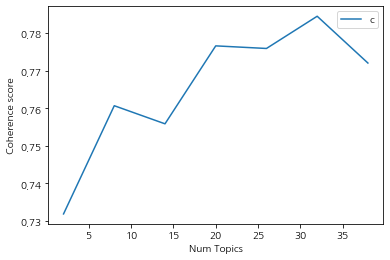

In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7319
Num Topics = 8  has Coherence Value of 0.7607
Num Topics = 14  has Coherence Value of 0.7559
Num Topics = 20  has Coherence Value of 0.7766
Num Topics = 26  has Coherence Value of 0.7759
Num Topics = 32  has Coherence Value of 0.7845
Num Topics = 38  has Coherence Value of 0.772


In [30]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(10,
  '0.231*"위해서" + 0.077*"발표를" + 0.077*"대북지원을" + 0.077*"바로" + 0.038*"갈등을" + '
  '0.038*"차질없이" + 0.038*"주실" + 0.038*"것처럼" + 0.038*"긴밀한" + 0.038*"마음이"'),
 (19,
  '0.100*"드립니다" + 0.100*"것입니다" + 0.033*"없앨수는" + 0.033*"요청한" + 0.033*"단체장들" + '
  '0.033*"대표회의" + 0.033*"등기부와" + 0.033*"모아졌습니다" + 0.033*"여기에" + 0.033*"가능성을"'),
 (29,
  '0.125*"하겠습니다" + 0.075*"있습니다" + 0.050*"점검하고" + 0.025*"집중할" + 0.025*"불쌍한" + '
  '0.025*"일자리" + 0.025*"집회" + 0.025*"오늘의" + 0.025*"정책역량을" + 0.025*"부동산"'),
 (5,
  '0.059*"명복을" + 0.059*"부담이" + 0.029*"임해야" + 0.029*"삼아서" + 0.029*"비어퐁" + '
  '0.029*"중단해야" + 0.029*"위험요소들을" + 0.029*"합의가" + 0.029*"제시한" + 0.029*"가족들"'),
 (6,
  '0.074*"국민이" + 0.074*"대출" + 0.037*"돈은" + 0.037*"공정거래에" + 0.037*"살펴보고" + '
  '0.037*"용납하지" + 0.037*"점검하도록" + 0.037*"유출과" + 0.037*"늘리고" + 0.037*"인내심에"'),
 (24,
  '0.087*"학생들이" + 0.087*"그리고" + 0.087*"노력하는" + 0.043*"온누리상품권" + 0.043*"종합대책을" '
  '+ 0.043*"오늘과" + 0.043*"내렸습니다" + 0.043*"나도" + 0.043*"희생자가" + 0.043*"상생하고"'),
 (11,
  '0.061*"문화를" + 0.061*"채우기" + 

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/alex/Documents/ai/business_model/voicemagic/env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,30.0,0.0437,"대책을, 점검하고, 청와대, 재검토하겠다고, 본회의에서, 유가족들에게, 기원합니다,...","네, 반갑습니다."
1,1,24.0,0.0639,"학생들이, 그리고, 노력하는, 온누리상품권, 종합대책을, 오늘과, 내렸습니다, 나도...",제 125차 정책조정회의 일을 상영표 원내대표에 모두 바로 가겠습니다.
2,2,2.0,0.0446,"결단을, 했습니다, 보일러와, 대응책을, 것입니다, 대규모집회도, 하청노동자들의, ...",11 12 월 이렇게 분위기가 이제 일주일 앞으로 다가왔습니다.
3,3,31.0,0.0761,"깼어, 노니의, 반드시, 발생하지, 위험의, 시간에, 올렸던, 인상했습니다, 외국인...",여야가 민생법안 처리를 위해서 노니의 속도를 더 내야겠습니다.
4,4,15.0,0.0442,"최선을, 응답해, 기쁨입니다, 받은, 오세암니다, 현장과, 실제로, 예의바른, 앞으...",꼭 처리해야 할 일이 또 과제는 6300번 산업안전보건법입니다.
5,5,21.0,0.0537,"바랍니다, 기하겠습니다, 방해하고, 빨리, 법안소위에서, 택시업계는, 예정입니다, ...",하나유치원 선법은 오늘의 연애 법안소위에서 어머니들 예정입니다.
6,6,8.0,0.0607,"혁신과, 설치, 처리될, 인상입니다, 자영업자, 무엇을, 있었고, 산업재해를, 어렵...",오늘 합의가 이루어지지 않을 경우 27분에 철인가 사실상 어렵습니다.
7,7,31.0,0.0547,"깼어, 노니의, 반드시, 발생하지, 위험의, 시간에, 올렸던, 인상했습니다, 외국인...",자유한국당 너 우리 아이들이 하는 마음이 조금이라도 있다면 6003번 노니의 접수 ...
8,8,6.0,0.0773,"국민이, 대출, 돈은, 공정거래에, 살펴보고, 용납하지, 점검하도록, 유출과, 늘리...",지난번 정기국회 때처럼 법안처리를 연 시키려는 무슨 국민이 용납하지 않을 것입니다.
9,9,3.0,0.0442,"사망사고를, 한미양국이, 술수도, 있습니다이, 안전관리실태, 가져오는, 착각은, 일...",우리당은 오늘 처리될 수 있도록 최선을 다해서 열린 자세로 소방서에 임하겠습니다.


In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0759,"있습니다, 노력을, 기준, 있도록, 프랜차이즈, 체계를, 택시업계가, 선제적으로, ...",21일 공청회 그리고 법안소위 내가 최대한 노력을 해서 24일까지는 전체의 1일까지...
1,1.0,0.0644,"통해서, 집회를, 중요한, 교통시설, 종합대책이, 밀어주는업자인지는, 계기가, 인한...",사실 쉽지 않은 그런 탑이었습니다만은 이 문제를 우리가 머리를 맞대고 대화와 타협을...
2,2.0,0.0596,"결단을, 했습니다, 보일러와, 대응책을, 것입니다, 대규모집회도, 하청노동자들의, ...",이런 합의를 이끌어 내기까지 우리 당의 전현희 의원께서 많은 노력을 했습니다.
3,3.0,0.0463,"사망사고를, 한미양국이, 술수도, 있습니다이, 안전관리실태, 가져오는, 착각은, 일...",연결 부위 문제로 인한 일산화탄소 노출입니다.
4,5.0,0.0653,"명복을, 부담이, 임해야, 삼아서, 비어퐁, 중단해야, 위험요소들을, 합의가, 제시...",선물하신 것처럼 이렇게 위장하는 술수도 보였다라고 하는 것을 말씀드리겠습니다.


In [33]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,30.0,"대책을, 점검하고, 청와대, 재검토하겠다고, 본회의에서, 유가족들에게, 기원합니다,...",8.0,0.0678
1,24.0,"학생들이, 그리고, 노력하는, 온누리상품권, 종합대책을, 오늘과, 내렸습니다, 나도...",3.0,0.0254
2,2.0,"결단을, 했습니다, 보일러와, 대응책을, 것입니다, 대규모집회도, 하청노동자들의, ...",6.0,0.0508
3,31.0,"깼어, 노니의, 반드시, 발생하지, 위험의, 시간에, 올렸던, 인상했습니다, 외국인...",3.0,0.0254
4,15.0,"최선을, 응답해, 기쁨입니다, 받은, 오세암니다, 현장과, 실제로, 예의바른, 앞으...",NaN,NaN
5,21.0,"바랍니다, 기하겠습니다, 방해하고, 빨리, 법안소위에서, 택시업계는, 예정입니다, ...",4.0,0.0339
6,8.0,"혁신과, 설치, 처리될, 인상입니다, 자영업자, 무엇을, 있었고, 산업재해를, 어렵...",6.0,0.0508
7,31.0,"깼어, 노니의, 반드시, 발생하지, 위험의, 시간에, 올렸던, 인상했습니다, 외국인...",1.0,0.0085
8,6.0,"국민이, 대출, 돈은, 공정거래에, 살펴보고, 용납하지, 점검하도록, 유출과, 늘리...",6.0,0.0508
9,3.0,"사망사고를, 한미양국이, 술수도, 있습니다이, 안전관리실태, 가져오는, 착각은, 일...",4.0,0.0339
